<a href="https://colab.research.google.com/github/OleksiiLatypov/Practical_Deep_Learning_with_PyTorch/blob/main/week3/template_unet_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation with UNet

Hi and welcome! In this lab, you will have an opportunity to solve an image segmentation problem. Here, we will use one of the most popular image segmentation architectures, UNet, to classify pixels of a brain into tumor/no tumor classes. Let's get started!

**GPU** is recomended for this assignment. `Runtime` -> `Change runtime type` -> `GPU`

**Instructions**
- Write code in the space indicated with `### START CODE HERE ###`
- Do not use loops (for/while) unless instructions explicitly tell you so. Parallelization in Deep Learning is key!
- If you get stuck, ask for help in Slack or DM `@DRU Team`

**You will learn**
- How to build an image segmentation algorithm
    - How to build a custom PyTorch dataset
    - How to define custom transforms
    - How to train and evaluate image segmentation model

# 0 - Download data

In [1]:
!pip install wget
import wget
wget.download('https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/3_conv_nn/unet_image_segmentation/template.zip')
!unzip -q template.zip

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=d5f55dda3ba7cce5537f6a4d08567f6af3060b561d81ec51fc162b02e91c4179
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


# 1 - Import packages and set up the environment

Let's import our regular packages. We also import `transforms.functional as TF`, which implements a lot of useful functions for implementing custom `transforms`. Use [this](https://pytorch.org/vision/stable/transforms.html#functional-transforms) documentation to read more about the functional transforms.

In [3]:
import torch
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF

import random
import os, shutil
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

%matplotlib inline

## Config

We will use different `batch_size` for training and evaluation to speed up the evaluation process. Also, as you can see from Config, the input to the model is an image of shape $(256, 256, 3)$, while the output is $(256, 256, 1)$. This is because our segmented image has only two classes, so it's enough to use a single value to represent the probability that a pixel is in a tumor region of the brain.

In [5]:
# VALIDATION_FIELD[cls] Config

class Config:
    # data preprocessing
    data_dir = 'BrainMRI/kaggle_3m/'
    logdir = 'logdir'
    validation_fraction = 0.15
    test_fraction = 0.10
    train_batch = 16
    valid_batch = 32
    test_batch = 32

    # model setup
    input_dim = 256
    input_ch = 3
    output_dim = 256
    output_ch = 1

    # training
    seed = 21
    learning_rate = 0.01
    epochs = 30
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(Config.seed)

# 2 - Data Preprocessing and visualizations

For this problem, we will be using [Brain MRI segmentation](https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation) from Kaggle. It contains 3929 images of Brain MRI and corresponding tumor masks, hand-labeled by professionals. Each Brain MRI is a regular 3-channel 256 by 256 image, while its segmentation mask is a 1-channel image with the same dimensions. The value of 255 in the mask denotes tumor regions.

Let's start with some data preprocessing:

## Get paths to images and corresponding masks

In [7]:
dirs, images, masks = [], [], []
for root, folders, files in os.walk(Config.data_dir):
    for file in files:
        # save only images with corresponding masks
        if 'mask'in file:
            dirs.append(root.replace(Config.data_dir, ''))
            masks.append(file)
            images.append(file.replace('_mask', ''))

PathDF = pd.DataFrame({'directory': dirs, 'images': images, 'masks': masks})
PathDF.head()

,directory,images,masks
0,TCGA_DU_6407_19860514,TCGA_DU_6407_19860514_52.tif,TCGA_DU_6407_19860514_52_mask.tif
1,TCGA_DU_6407_19860514,TCGA_DU_6407_19860514_36.tif,TCGA_DU_6407_19860514_36_mask.tif
2,TCGA_DU_6407_19860514,TCGA_DU_6407_19860514_25.tif,TCGA_DU_6407_19860514_25_mask.tif
3,TCGA_DU_6407_19860514,TCGA_DU_6407_19860514_38.tif,TCGA_DU_6407_19860514_38_mask.tif
4,TCGA_DU_6407_19860514,TCGA_DU_6407_19860514_14.tif,TCGA_DU_6407_19860514_14_mask.tif


## Train/Test/Val Split

In [9]:
train2rest = Config.validation_fraction + Config.test_fraction
test2valid = Config.validation_fraction/train2rest

train_df, rest = train_test_split(
    PathDF, random_state=Config.seed,
    test_size=train2rest
)

test_df, valid_df = train_test_split(
    rest, random_state=Config.seed,
    test_size=test2valid
)

print('Train:', train_df.shape[0])
print('Valid:', valid_df.shape[0])
print('Test:', test_df.shape[0])

Train: 2946
Valid: 590
Test: 393


**Expected output:**
<table>
    <tr>
        <td><b>Train</b>
        </td>
        <td>2946</td>
    </tr>
    <tr>
        <td><b>Valid</b>
        </td>
        <td>590</td>
    </tr>
    <tr>
        <td><b>Test</b>
        </td>
        <td>393</td>
    </tr>
</table>

## Visualize Examples

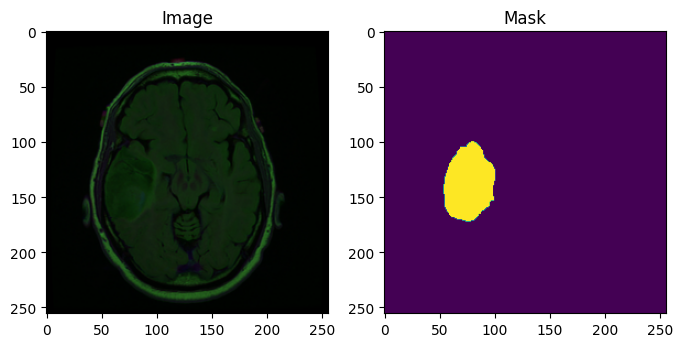

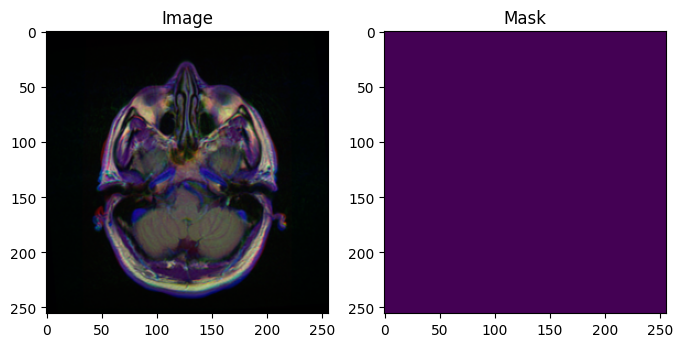

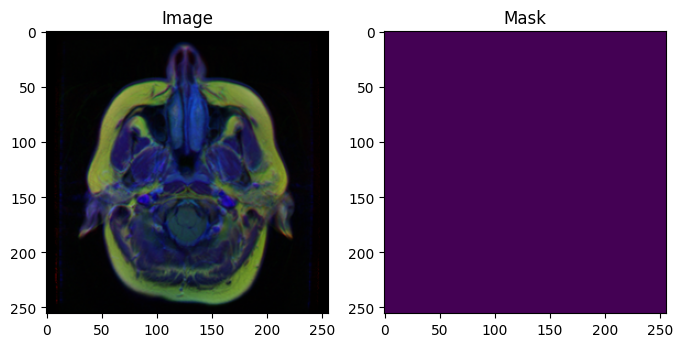

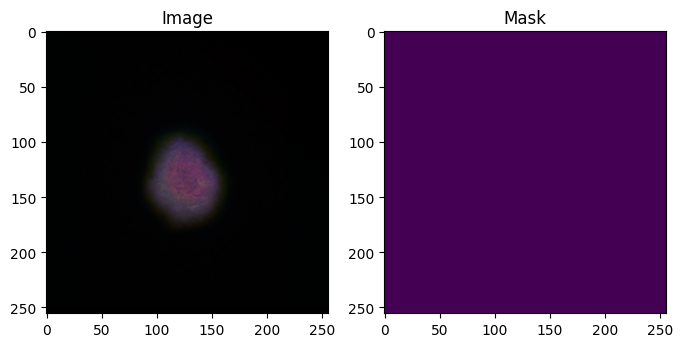

In [14]:
def plot_example(idx):
    base_path = os.path.join(Config.data_dir, test_df['directory'].iloc[idx])
    img_path = os.path.join(base_path, test_df['images'].iloc[idx])
    mask_path = os.path.join(base_path, test_df['masks'].iloc[idx])
    img = Image.open(img_path)
    mask = Image.open(mask_path)

    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    ax[0].imshow(img)
    ax[0].set_title('Image')
    ax[1].imshow(mask)
    ax[1].set_title('Mask')
    plt.show()

plot_example(54)
plot_example(123)
plot_example(246)
plot_example(346)

## Dataset class

Here we will define our custom PyTorch Dataset that will load the image and its mask as one data sample.

To implement PyTorch **Dataset** we have to inherit from the generic PyTorch `Dataset` class and implement the follwing:

1. ` __init__`
2. `__len__`
3. `__getitem__`


### 1.`__init__`
The `__init__` method is responsible for initializing your dataset and saving the meta-information about extracting data samples from the dataset. Usually, it is a list of path strings or links. In our case, it's a data frame containing path and file names. We also save `transforms` in the `__init__` function to apply them later during image extraction.

### 2.`__len__`
This method is needed for the `Dataset` to understand the number of examples, and for a `Dataloader` to calculate the number of batches.

### 3.`__getitem__`
This method simply extracts a single data sample by a numeric `id`. This `id` parameter should be in range `[0, len - 1]`. Then we just have to implement the logic of extracting and loading a given sample. In our case, it is as simple as reconstructing the image path from DataFrame, and loading image and its corresponding mask using `Image.open()`. Also, we have to apply `transforms` on both the image and its segmentation mask.

In [15]:
class MRI_Dataset(Dataset):
    def __init__(self, path_df, transform=None):
        self.path_df = path_df
        self.transform = transform

    def __len__(self):
        return self.path_df.shape[0]

    def __getitem__(self, idx):
        base_path = os.path.join(Config.data_dir, self.path_df.iloc[idx]['directory'])
        img_path = os.path.join(base_path, self.path_df.iloc[idx]['images'])
        mask_path = os.path.join(base_path, self.path_df.iloc[idx]['masks'])

        image = Image.open(img_path)
        mask = Image.open(mask_path)

        sample = (image, mask)
        # we would need to apply the same transform
        # on both image and a mask
        if self.transform:
            sample = self.transform(sample)

        return sample

## Custom Transforms

Our dataset requires us to apply the **same** transformations on both the mask and the image. For example, if we are using a random rotation, we have to randomly rotate both the image and its mask by the same angle. Therefore, we cannot simply call `transforms.RandomRotation` twice because this will rotate the mask differently from the original image.

So, let's implement our own custom `transforms`! To do so, we simply have to create a class with `__init__` and `__call__` methods. To perform the transformations themselves, we will be using functional transforms.

### Functional Transforms
From PyTorch official [documentation](https://pytorch.org/vision/stable/transforms.html#functional-transforms):

Functional transforms give you fine-grained control of the transformation pipeline. As opposed to the transformations above, functional transforms don’t contain a random number generator for their parameters. That means you have to specify/generate all parameters, but the functional transform will give you reproducible results across calls.

### Random Flip

**Excercise:** implement `PairedRandomHorizontalFlip` transform that horizontally flips both the image and the mask.

Hints:
* use `np.random.random()` to generate a random number
* to flip an image use `TF.hflip`

In [16]:
# VALIDATION_FIELD[cls] PairedRandomHorizontalFlip

class PairedRandomHorizontalFlip():
    """Custom transform for horizontal flipping"""
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, sample):
        """
        Randomly flips both of the images

        Arguments:
        sample - tuple, image and segmentation mask

        Returns:
        (img, mask) - tuple, transformed sample
        """
        img, mask = sample
        ### START CODE HERE ### (≈ 3 lines of code)
        if np.random.random() < self.prob:
          img = TF.hflip(img)
          mask = TF.hflip(mask)


        ### END CODE HERE ###
        return img, mask

In [19]:
def show_sample(sample, title=None):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(sample[0])
    ax[1].imshow(sample[1], cmap='gray')
    if title:
        fig.suptitle(title)
    plt.show()

dataset = MRI_Dataset(test_df)
sample = dataset[4]

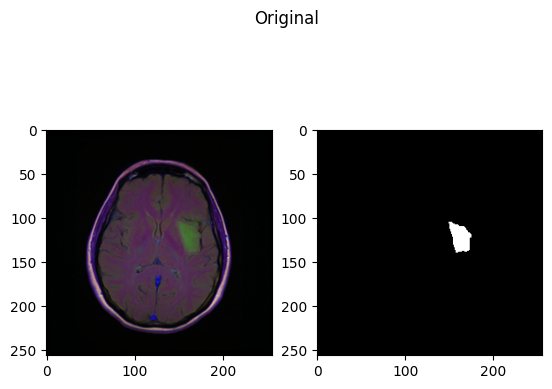

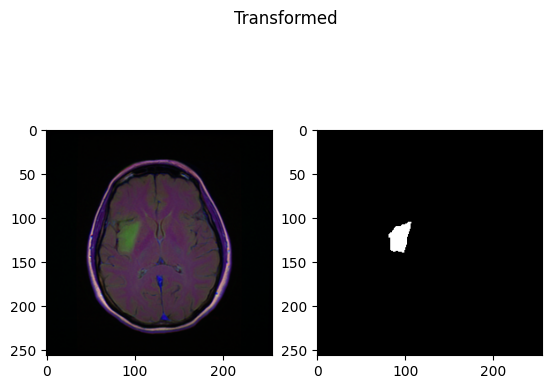

In [18]:
transform = PairedRandomHorizontalFlip(prob=1)
show_sample(sample, title='Original')
show_sample(transform(sample), title='Transformed')

### Random Affine

Next on our list is Random Affine transformation. To apply random affine on both the image and its mask, you will need to use `get_params` function to extract the parameters of random flipping from `RandomAffine` function.

**Excercise:** implement `PairedRandomAffine` transformation.

In [74]:
# VALIDATION_FIELD[cls] PairedRandomAffine
import torchvision
class PairedRandomAffine():
    """
    Randomly applies affine transformation
    on both of the images
    """
    def __init__(self, degrees=1, translate=2, scale=2, shears=2):

        self.params = {
            'degrees': degrees,
            'translate': translate,
            'scale_ranges': scale,
            'shears': shears
        }

    def __call__(self, sample):
        ### START CODE HERE ### (≈ 5 lines of code)
        img, mask = sample
        # find dimensions using img
        w, h = img.size
        # extract parameters from trasnforms.RandomAffine
        angle, translations, scale, shear = torchvision.transforms.RandomAffine(**self.params)
        # apply TF.affine using fixed parameters
        img = TF.affine(img, angle, translations, scale, shear)
        mask = TF.affine(mask, angle, translations, scale, shear)
        ### END CODE HERE ###
        return img, mask

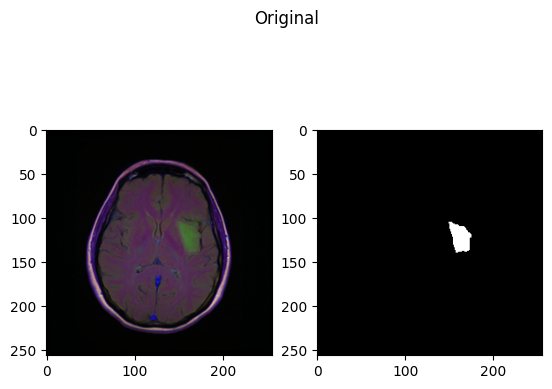

TypeError: RandomAffine.__init__() got an unexpected keyword argument 'scale_ranges'

In [76]:
transform = PairedRandomAffine(
    degrees=(15, 15),
    scale=(1.2, 1.2)
)
# check if it visually works
show_sample(sample, 'Original')
show_sample(transform(sample), 'Transformed')

## ToTensor

Last but not least, we will have to implement paired `ToTensor` transform. Technically, we can use `transforms.ToTensor` twice since it's not a random function. However, writing this function on our own will give us a deeper understanding of how the actual conversion works.

**Excercise:** implement `PairedToTensor` transform that transforms both image and its mask to float tensors with values in [0, 1] range.

Implement the following:

* Convert image and mask to NumPy arrays.
* Expand the last dimension for the mask from $(H,W,)$ to $(H, W, 1)$.
* Transpose both arrays to make the number of channels first dimension.
    * [H, W, C] should become [C, H, W].
    * Do not use `.T()` on numpy array, because it changes the order of the last two dimensions (i.e. [H, W, C] will become [H, C, W]). See `.transpose` documentation instead.
* Convert to `torch.tensor` of float data type.
* Normalize to a $[0, 1]$ range by dividing all entries in the input by 255.

In [ ]:
# VALIDATION_FIELD[cls] PairedToTensor

class PairedToTensor():
    """
    Convert ndarrays in sample to Tensors.
    """
    def __call__(self, sample):
        ### START CODE HERE ### (≈ 7 lines of code)

        ### END CODE HERE ###
        return img, mask

In [ ]:
trasnform = PairedToTensor()
img, mask = trasnform(sample)
print('image shape:', img.shape)
print('mask shape:', mask.shape)

**Expected output:**
    
<table>
    <tr>
        <td><b>image shape</b></td>
        <td>torch.Size([3, 256, 256])
        </td>
    </tr>
    <tr>
        <td><b>mask shape</b></td>
        <td>torch.Size([1, 256, 256])
        </td>
    </tr>

</table>

## Data Loaders

Using `transforms.Compose`, we will combine our transformations into one variable, and using them, we will create datasets and dataloaders.

In [ ]:
train_transforms = transforms.Compose([
    PairedRandomHorizontalFlip(),
    PairedRandomAffine(
        degrees=(-15, 15),
        translate=(0.1, 0.1),
        scale_ranges=(0.8, 1.2)
    ),
    PairedToTensor()
])
eval_transforms = PairedToTensor()

train_data = MRI_Dataset(train_df, transform=train_transforms)
valid_data = MRI_Dataset(valid_df, transform=eval_transforms)
test_data = MRI_Dataset(test_df, transform=eval_transforms)

train_loader = DataLoader(train_data, batch_size=Config.train_batch, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_data, batch_size=Config.valid_batch, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=Config.test_batch, shuffle=False, num_workers=2)

# 3 - Building a model

<img src="https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/ntbk_images/unet_network.png">

For this task, we will use UNet architecture developed by Olaf Ronneberger et al. for BioMedical Image Segmentation. The architecture contains two paths. The first path is the contraction path (also called the encoder) which is used to capture the context in the image. The encoder is a traditional stack of convolutional and max-pooling layers. The second path is the symmetric expanding path (also called as the decoder), which is used to enable precise localization using transposed convolutions. Thus it is an end-to-end fully convolutional network **FCN**, because it only contains Convolutional layers and does not contain any Dense layers, which means that it can accept images of any size.

Let's get started and implement components of UNet architecture!

## Main block

This time for building a model, we will take a slightly different approach. Instead of using a function that returns a sequential block, we will implement our own `nn.Module` sub-classes and implement `forward`, and `__init__` for them.

The most basic building block of the UNet architecture is `DoubleConv` block. It contains two `Conv2d` layers followed by `BatchNorm` layers and `RelU` activation functions. For Convolutional layers, we will use 3x3 convolutions with a `stride=1` and `padding=1` (note that in the original architecture, there was no padding used). For ReLU activations, we will use `inplace=True` to speed up the training.

**Excercise:** Your task will be to implement a Double Convolutional block for a Neural Network.

**Hints:**
* It should contain `Conv2d(in_ch, out_ch)` -> `BatchNorm2d` -> `ReLU` -> `Conv2d(out_ch, out_ch)` -> `BatchNorm2d` -> `ReLU`.
* `kernel_size` for `Conv2d` is 3x3
* Use `padding=1`
* Use `inplace=True` for `ReLU`
* Use default value for `bias` (i.e. no need to specify `bias=True`)

In [ ]:
# VALIDATION_FIELD[cls] DoubleConv

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        ### START CODE HERE ###
        self.conv = nn.Sequential( ... )
        ### END CODE HERE ###
    def forward(self, x):
        x = self.conv(x)
        return x

In [ ]:
x = torch.randn((1, 3,  256, 256))
DConv = DoubleConv(3, 6)
print('Output shape:', DConv(x).shape)

**Expected output:**
<table>
<tr>
    <td> <b>output shape</b> </td>
    <td> torch.Size([1, 6, 256, 256]) </td>
</tr>
</table>

## Input block
Next, we will implement input block for our Neural Network. Essentially, it is just a wrapper around `DoubleConv`, but it makes the model layout look more organized.

In [ ]:
# VALIDATION_FIELD[cls] InConv

class InConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(InConv, self).__init__()
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x):
        x = self.conv(x)
        return x

## Down block

This block is the main block of UNet encoder architecture. It decreases spatial dimension by two and increases the number of channels by stacking together `MaxPooling` and `DoubleConv`.

**Excercise:** Implement `Down` block of UNet architecture:
* To decrease the spatial dimension by half, use `MaxPooling`.
* To increase the number of channels use `DoubleConv` defined above.

In [57]:
# VALIDATION_FIELD[cls] Down

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        ### START CODE HERE ###
        self.mpconv = nn.Sequential( ... )
        ### END CODE HERE ###
    def forward(self, x):
        x = self.mpconv(x)
        return x

Ignore the `UserWarning:` from `torch.max_pool2d`

In [58]:
x = torch.randn((1, 3,  256, 256))
print('Output shape:', Down(3, 6)(x).shape)

TypeError: ellipsis is not a Module subclass

**Expected output:**
<table>
<tr>
    <td> <b>output shape</b> </td>
    <td> torch.Size([1, 6, 128, 128]) </td>
</tr>
</table>

## Up block

Here we will implement upscaling block for a decoder network. Similar to **ResNet18**, UNet architecture uses a residual connection to improve the gradient flow to the earlier layers of the network. Each upscaling block takes the output of the previous layer `x1` and upscales it using **trasnpose convolution** layer, increasing the spatial dimension by a factor of 2. Then, it takes the output of the corresponding down layer, `x2`, and concatenates it with `x1`. Finally, we pass them through the regular `DoubleConv` block.
**Note** In the original architecture, researchers used padding to ensure that `x1.shape` == `x2.shape`. In our case, we don't have to use paddings because we know that `x2` will always be twice as big as `x1`.

**Excercise:** your task will be to implement `forward` method of `Up` network.
1. Upscale `x1` using transpose convolutions
2. Concatenate the inputs across the channel dimension
3. Pass the concatenated tensor through `DoubleConv`

In [ ]:
# VALIDATION_FIELD[cls] Up

class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x1, x2):
        ### START CODE HERE ### (≈ 3 lines of code)

        ### END CODE HERE ###
        return x

In [ ]:
x1 = torch.randn((1, 8, 32, 32))
x2 = torch.randn((1, 8, 64, 64))
print('Output shape:', Up(16, 8)(x1, x2).shape)

**Expected output:**
<table>
<tr>
    <td> <b>output shape</b> </td>
    <td> torch.Size([1, 8, 64, 64]) </td>
</tr>
</table>

## Output block

Here, we will add one output layer which uses 1x1 convolutions to decrease the number of channels, and passes the outputs through the sigmoid activation function.

In [ ]:
# VALIDATION_FIELD[cls] OutConv

class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.conv(x)
        x = self.sigmoid(x)
        return x

## Model Class

Let's combine everything together.

**Excercise:** implement UNet architecture using layers defined above.
* The progression of input channels for encoder blocks should be: `3(input)` -> `64` -> `128` -> `256` -> `512` -> `512`.
* The progression of output channels for decoder should be: `256` -> `128` -> `64` -> `64` -> `1(output)`.
* Use the diagaram in order to replace all `?` with the correct number of channels.
* For the `forward` method you need to remember outputs of the first 5 layers to use them as residual inputs in Up blocks.

In [ ]:
# VALIDATION_FIELD[cls] UNet

class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()
        ### START CODE HERE ### (≈ 10 lines of code)
        self.inc = InConv(in_channels, ?)
        self.down1 = Down(64, ?)
        self.down2 = Down(128, ?)
        self.down3 = Down(256, ?)
        self.down4 = Down(512, ?)
        self.up1 = Up(?, 256)
        self.up2 = Up(?, 128)
        self.up3 = Up(?, 64)
        self.up4 = Up(?, 64)
        self.outc = OutConv(?, num_classes)
        ### END CODE HERE ###
    def forward(self, x):
        ### START CODE HERE ### (≈ 10 lines of code)

        ### END CODE HERE ###
        return x

In [ ]:
x = torch.randn(1, 3, 256, 256)
print('output shape:', UNet(3, 1)(x).shape)

**Expected output:**
<table>
<tr>
    <td> <b>output shape</b> </td>
    <td> torch.Size([1, 1, 256, 256]) </td>
</tr>
</table>

# 4 - Training the model

Next, we will define **train loop** and **validation loop** separately and then combine them in the overall `train` function.

## Train Loop

**Excercise:** define function `train_loop` that performs one epoch of training.
* Don't forget to multiply the value of the loss by the current batch size before adding it to the `running_loss`

In [ ]:
# VALIDATION_FIELD[func] train_loop

def train_loop(model, optimizer, criterion, train_loader, device=Config.device):
    running_loss = 0
    model.train()
    pbar = tqdm(train_loader, desc='Iterating over train data')
    for imgs, masks in pbar:
        ### START CODE HERE ###
        # pass to device
        imgs =
        masks =
        # forward
        out =
        loss =
        running_loss +=  # += loss * current batch size
        # optimize

        ### END CODE HERE ###
    running_loss /= len(train_loader.sampler)
    return running_loss

In [ ]:
# create a lightweight model for testing purposes
set_seed(Config.seed)
model = nn.Sequential(
    nn.Conv2d(3, 1, kernel_size=(1, 1)),
    nn.Sigmoid()
    ).to(Config.device)
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()
# we will use test_loader to speed up testing
loss = train_loop(model, optimizer, criterion, test_loader)
print('Train loss:', loss)

**Expected output:**
<table>
<tr>
    <td><b>Train loss:</b></td>
    <td>0.4507112026821263</td>
</tr>
</table>

## Evaluation loop


In the `evaluate_loop,` we will perform our regular validation procedure. We will compute three metrics:
* loss
* accuracy
* f1_score

Compared to the previous validation loops, the only difference is that we will perform metrics calculations for each batch and then average the results. The reason for that is because our output has a shape of $[32, 1, 256, 256]$, which means that every batch is a tensor of $32*256*256=2097152$. Therefore, it would be impractical to save all of the outputs to perform the metric calculation.

**Excercise:** Implement `eval_loop`

In [ ]:
# VALIDATION_FIELD[func] eval_loop

def eval_loop(model, criterion, eval_loader, device=Config.device):
    running_loss = 0
    model.eval()
    with torch.no_grad():
        accuracy, f1_scores = [], []
        pbar = tqdm(eval_loader, desc='Iterating over evaluation data')
        for imgs, masks in pbar:
            ### START CODE HERE ### (≈ 7 lines of code)
            # pass to device

            # forward

            # calculate predictions using output
            predicted =
            ### END CODE HERE ###
            predicted = predicted.view(-1).cpu().numpy()
            labels = masks.view(-1).cpu().numpy()
            accuracy.append(accuracy_score(labels, predicted))
            f1_scores.append(f1_score(labels, predicted))
    acc = sum(accuracy)/len(accuracy)
    f1 = sum(f1_scores)/len(f1_scores)
    running_loss /= len(eval_loader.sampler)
    return {
        'accuracy':acc,
        'f1_macro':f1,
        'loss':running_loss}

In [ ]:
# create a lightweight model for testing purposes
set_seed(Config.seed)
model = nn.Sequential(
    nn.Conv2d(3, 1, kernel_size=(1, 1)),
    nn.Sigmoid()
    ).to(Config.device)
criterion = nn.BCELoss()
metrics = eval_loop(model, criterion, valid_loader)
print('Accuracy:', metrics['accuracy'])
print('F1 macro:', metrics['f1_macro'])
print('Loss:', metrics['loss'])

**Expected output:**
<table>
<tr>
    <td><b>Accuracy:</b></td>
    <td>0.9901577225305085</td>
</tr>
<tr>   
    <td><b>F1 macro:</b></td>
    <td>0.0</td>
</tr>
<tr>   
    <td><b>Loss:</b></td>
    <td>0.45371486150612267</td>
</tr>
</table>

## Overall train fucntion

In the `train` function, we will add tensorboard. This usefull util will allow us to track the metrics of interest during the training process.

In [ ]:
def train(model, optimizer, criterion, train_loader, valid_loader,
          device=Config.device,
          num_epochs=Config.epochs,
          valid_loss_min=np.inf,
          logdir=Config.logdir):

    tb_writer = SummaryWriter(log_dir=logdir)
    for e in range(num_epochs):
        # train for epoch
        train_loss = train_loop(
            model, optimizer, criterion, train_loader, device=device)
        # evaluate on validation set
        metrics = eval_loop(
            model, criterion, valid_loader, device=device
        )
        # show progress
        print_string = f'Epoch: {e+1} '
        print_string+= f'TrainLoss: {train_loss:.5f} '
        print_string+= f'ValidLoss: {metrics["loss"]:.5f} '
        print_string+= f'ACC: {metrics["accuracy"]:.5f} '
        print_string+= f'F1: {metrics["f1_macro"]:.3f}'
        print(print_string)

        # Tensorboards Logging
        tb_writer.add_scalar('UNet/Train Loss', train_loss, e)
        tb_writer.add_scalar('UNet/Valid Loss', metrics["loss"], e)
        tb_writer.add_scalar('UNet/Accuracy', metrics["accuracy"], e)
        tb_writer.add_scalar('UNet/F1 Macro', metrics["f1_macro"], e)

        # save the model
        if metrics["loss"] <= valid_loss_min:
            torch.save(model.state_dict(), 'UNet.pt')
            valid_loss_min = metrics["loss"]

In [ ]:
# to start TensorBoard in Google Colab run the following command
%load_ext tensorboard
%tensorboard --logdir logs

In Google Colab one epoch takes approximately 2.5 minutes. You **don't** have to finish training the model to submit your assignment.

In [ ]:
set_seed(Config.seed)
model = UNet(Config.input_ch, Config.output_ch).to(Config.device)
optimizer = optim.Adam(model.parameters(), lr=Config.learning_rate)
criterion = nn.BCELoss()
train(model, optimizer, criterion, train_loader, valid_loader)

**Expected Output:**

```
Epoch: 1 TrainLoss: 0.05373 ValidLoss: 0.02526 ACC: 0.99208 F1: 0.369
Epoch: 2 TrainLoss: 0.02245 ValidLoss: 0.01806 ACC: 0.99466 F1: 0.663
Epoch: 3 TrainLoss: 0.01965 ValidLoss: 0.01821 ACC: 0.99433 F1: 0.683
Epoch: 4 TrainLoss: 0.01925 ValidLoss: 0.02443 ACC: 0.99355 F1: 0.700
Epoch: 5 TrainLoss: 0.01794 ValidLoss: 0.01624 ACC: 0.99521 F1: 0.709
```

# 5 - Model Evaluation

In [ ]:
# Load the latest model
model.load_state_dict(torch.load('UNet.pt'))
metrics = eval_loop(model, criterion, test_loader)
print('accuracy:', metrics['accuracy'])
print('f1 macro:', metrics['f1_macro'])
print('test loss:', metrics['loss'])

**Expected Output** (after 30 epochs):
<table>
<tr>
    <td> <b>accuracy</b> </td>
    <td> 0.9968137537312304 </td>
</tr>
<tr>
    <td> <b>f1 macro</b> </td>
    <td> 0.8288145082308138 </td>
</tr>
<tr>
    <td> <b>test loss</b> </td>
    <td> 0.008296167233878268 </td>
</tr>
</table>

## Visualizing the results

In [ ]:
def plot_predictions(model, idx):
    base_path = os.path.join(Config.data_dir, test_df['directory'].iloc[idx])
    img_path = os.path.join(base_path, test_df['images'].iloc[idx])
    mask_path = os.path.join(base_path, test_df['masks'].iloc[idx])

    img = Image.open(img_path)
    mask = Image.open(mask_path)

    tensor_img, tensor_mask = eval_transforms((img, mask))
    tensor_img = tensor_img.unsqueeze(0).to(Config.device)

    model.eval()
    with torch.no_grad():
        pred = model(tensor_img)[0].detach().cpu().numpy()
        pred = pred.transpose((1, 2, 0)).squeeze()
        rounded = np.round(pred)

    plot_images = {'Image': img,
                   'Mask': mask,
                   'Predicted Mask': pred,
                   'Predicted Rounded Mask': rounded}

    fig, ax = plt.subplots(1, 4, figsize=(16,4))
    for i, key in enumerate(plot_images.keys()):
        ax[i].imshow(plot_images[key])
        ax[i].set_title(key)
    plt.show()

plot_predictions(model, 54)
plot_predictions(model, 123)
plot_predictions(model, 246)
plot_predictions(model, 346)

# Try your own !

Just kidding :) We hope you won't need to